In [3]:
import os,sys,string,time,glob,h5py
import illustris_python as il
import illustris_tools as it
import numpy as np
import pandas as pd

def Mergers_Catalogue(basePath,sim,snap,little_h=0.6774):
    
    massmax = pd.read_csv(
        f'{basePath}/MassMax/{sim}_MassMax_{snap:03}.csv'
    )
    mergers = np.load(
        f'{basePath}/Mergers/{sim}_Mergers_{snap:03}.npz',
        allow_pickle=True
    )
    # all files have same keys 
    subs = [int(key) for key in mergers['major'][()].keys()]
    
    for type_merger in ['major','minor','tiny']:
        history = mergers[type_merger][()]
        
    cat = pd.DataFrame()
    
    for sub in subs:
        dbID = f'{snap}_{sub}'
        mass_idx = massmax.SubhaloID==sub
        mass_rec = massmax.loc[mass_idx]
        
        # append massmax catalogue fields
        r = {
            'dbID': f'{snap}_{sub}',
            'SnapNum': snap,
            'SubfindID': sub,
            'MaxMassSnap_stars': mass_rec[
                'SnapMaxSubhaloMassType_stars'
            ].values[0],
            'MaxMassType_stars': mass_rec[
                'MaxSubhaloMassType_stars'
            ].values[0],
            'MaxMassInRadSnap_stars': mass_rec[
                'SnapMaxSubhaloMassInRadType_stars'
            ].values[0],
            'MaxMassInRadType_stars': mass_rec[
                'MaxSubhaloMassInRadType_stars'
            ].values[0],
        }
        
        # append merger catalogue fields
        for i in ['Major','Minor','Tiny']:
            h = mergers[i.lower()][()][f'{sub}']
            r[f'{i}_Count']=h['MergerNum']
            r[f'{i}_CountSinceHalfScale']=h['MergerNumHalfScale']
            r[f'{i}_FrequencyMLP']=h['MergerFreqMLP']
            if len(h['MergerSnap'])>0:
                r[f'{i}_SnapNum']=h['MergerSnap'][0]
                r[f'{i}_LookbackTime']=h['MergerTpost'][0]
                r[f'{i}_MassRatio']=h['MergerMassRatio'][0]
                r[f'{i}_MaxMassNPB_stars']=h['MergerNPBMassStarsMax'][0]
                r[f'{i}_MaxMassNPB_gas']=h['MergerNPBMassStarsMax'][0]
                r[f'{i}_MaxMassMPB_stars']=h['MergerMPBMassStarsMax'][0]
                r[f'{i}_MaxMassMPB_gas']=h['MergerMPBMassGasMax'][0]
            else:
                r[f'{i}_SnapNum']=-1
                r[f'{i}_LookbackTime']=-1
                r[f'{i}_MassRatio']=-1
                r[f'{i}_MaxMassNPB_stars']=-1
                r[f'{i}_MaxMassNPB_gas']=-1
                r[f'{i}_MaxMassMPB_stars']=-1
                r[f'{i}_MaxMassMPB_gas']=-1

        cat = cat.append(r,ignore_index=True)
        
    cat = cat.astype({'SnapNum': int, 'SubfindID': int})
        
    return cat

def Mergers_SQL(cat,sim,snap,
                 host='nantai.ipmu.jp',user='bottrell',
                 cnf_path='/home/connor.bottrell/.mysql/nantai.cnf'):
    import pymysql
    database = f'Illustris{sim}'.replace('-','_')
    columns = list(cat.columns)
    
    db = pymysql.connect(host=host,
                         user=user,
                         database=database,
                         read_default_file=cnf_path,
                         autocommit=True
                        )
    c = db.cursor()
    for idx in cat.index:
        rec = cat.loc[idx]
        values = [str(rec[col]) for col in columns]
        values = ','.join(values)
        values = values.replace('nan','-2')
        values = values.replace('-inf','-2')
        values = values.replace('inf','-2')
        dbID = f'{rec["SnapNum"]}_{rec["SubfindID"]}'
        print(dbID)
        values = values.replace(f'{dbID}',f'"{dbID}"')
        dbcmd = [
            f'INSERT INTO Mergers',
            '(',','.join(columns),')',
            f'VALUES',
            f'(',values,')',
        ]
        dbcmd = ' '.join(dbcmd)
        print(dbcmd)
        try:
            c.execute(dbcmd)
        except:
            raise
    c.close()
    db.close()
    return

def main():
    
    from astropy.cosmology import Planck15 as cosmo
    
    sim,snap='TNG50-1',17
    
    mergerCatPath = f'/lustre/work/connor.bottrell/Simulations/IllustrisTNG/Scripts/Mergers/illustris_mergers/Catalogues'
    
    schemaCatPath = f'/lustre/work/connor.bottrell/Simulations/IllustrisTNG/Scripts/Schema/Catalogues'
    
    if not os.access(schemaCatPath,0):
        os.system(f'mkdir -p {schemaCatPath}')
        
    catName = f'{schemaCatPath}/{sim}_{snap:03}_Mergers.csv'
    
    if not os.access(catName,0):
        cat = Mergers_Catalogue(mergerCatPath,sim,snap,
                                little_h = cosmo.H0.value/100)

    Mergers_SQL(cat,sim,snap)

if __name__=='__main__':
    main()

ModuleNotFoundError: No module named 'illustris_tools'

,Major_Count,Major_CountSinceHalfScale,Major_FrequencyMLP,Major_LookbackTime,Major_MassRatio,Major_MaxMassMPB_gas,Major_MaxMassMPB_stars,Major_MaxMassNPB_gas,Major_MaxMassNPB_stars,Major_SnapNum,...,Tiny_CountSinceHalfScale,Tiny_FrequencyMLP,Tiny_LookbackTime,Tiny_MassRatio,Tiny_MaxMassMPB_gas,Tiny_MaxMassMPB_stars,Tiny_MaxMassNPB_gas,Tiny_MaxMassNPB_stars,Tiny_SnapNum,dbID
0,0.0,0.0,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,...,58.0,4.258539,0.000000,0.010905,4.208895,0.327827,0.003575,0.003575,17.0,17_0
1,1.0,1.0,0.073423,0.490090,0.631868,0.180934,0.005015,0.003169,0.003169,9.0,...,34.0,2.716654,0.245321,0.010314,0.343293,0.008584,0.000089,0.000089,13.0,17_1
2,6.0,4.0,0.443510,0.000000,0.390697,0.710394,0.027572,0.010772,0.010772,17.0,...,26.0,1.921877,0.000000,0.024514,0.710394,0.027572,0.000676,0.000676,17.0,17_2
3,8.0,7.0,0.587385,0.444836,0.637143,0.011836,0.000620,0.000395,0.000395,10.0,...,32.0,2.349539,0.140858,0.013078,0.016864,0.000312,0.000004,0.000004,15.0,17_3
4,2.0,1.0,0.146846,0.580891,0.264159,0.720605,0.021374,0.005646,0.005646,7.0,...,27.0,2.422962,0.211722,0.062556,3.687024,0.565719,0.035389,0.035389,14.0,17_1228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,5.0,5.0,0.367115,0.245321,0.315742,0.002564,0.000242,0.000076,0.000076,13.0,...,28.0,2.055847,0.000000,0.020253,0.002564,0.000242,0.000005,0.000005,17.0,17_40323
113,3.0,1.0,0.220269,0.758747,0.318994,0.039664,0.000614,0.000196,0.000196,3.0,...,7.0,0.513962,0.064814,0.056328,0.468366,0.035931,0.002024,0.002024,16.0,17_41984
114,2.0,1.0,0.146846,0.758747,0.798941,0.004941,0.000052,0.000065,0.000065,3.0,...,16.0,1.174770,0.211722,0.020072,0.118430,0.002614,0.000052,0.000052,14.0,17_42817
115,12.0,12.0,0.881077,0.211722,0.979154,0.003813,0.000098,0.000096,0.000096,14.0,...,16.0,1.174770,0.140858,0.028216,0.063209,0.001532,0.000043,0.000043,15.0,17_42995


In [46]:
import os,sys,time,h5py
import illustris_python as il
import numpy as np
import pandas as pd
from astropy.cosmology import Planck15 as cosmo

def query(dbcmd,database,
          host='nantai.ipmu.jp',user='bottrell',
          cnf_path='/home/connor.bottrell/.mysql/nantai.cnf'):
    '''Query database and return results as numpy array.'''
    import pymysql
    import numpy as np
    db = pymysql.connect(host=host,
                         user=user,
                         database=database,
                         read_default_file=cnf_path)
    c = db.cursor()
    c.execute(dbcmd)
    data = np.asarray(c.fetchall())
    c.close()
    db.close()
    return data

def submit(dbcmd,database,
           host='nantai.ipmu.jp',user='bottrell',
           cnf_path='/home/connor.bottrell/.mysql/nantai.cnf'):
    '''Submit command to database.'''
    import pymysql
    import numpy as np
    db = pymysql.connect(host=host,
                         user=user,
                         database=database,
                         read_default_file=cnf_path,
                         autocommit=True
                        )
    c = db.cursor()
    c.execute(dbcmd)
    c.close()
    db.close()
    return 

def Environment_Catalogue(basePath,massCatPath,sim,snap):
    '''
    mstar_lower and mstar_upper have log10(Mstar/Msun) units and are physical (i.e. Msun, not Msun/h). Requires that maximum masses have already been computed for every galaxy and are stored in the catalogues. These catalogues include masses for all subhalos with a stellar mass component.
    '''
    
    df = pd.DataFrame()
    
    little_h = cosmo.H0.value/100.
    ptNumStars = il.snapshot.partTypeNum('stars')
    ptNumGas = il.snapshot.partTypeNum('gas')
    ptNumDM = il.snapshot.partTypeNum('dm')
    
    # get list of halos to measure environments
    db_sim = sim.replace('-','_')
    database = f'Illustris{db_sim}'
    dbcmd = f'SELECT SubfindID FROM Subhalos WHERE SnapNum={snap}'
    db_subs = np.sort(query(dbcmd,database).flatten())
    
    # get full list of subhalos from groupcats
    fields = ['SubhaloPos','SubhaloMassType','SubhaloFlag']
    cat = il.groupcat.loadSubhalos(basePath,snap,fields=fields)
    hdr = il.groupcat.loadHeader(basePath,snap)
    redshift,a2 = hdr['Redshift'],hdr['Time']
    boxSize = hdr['BoxSize']
    # periodic coordinates
    cat_coords = cat['SubhaloPos']
    
    # get maximum masses from catalogue
    massmax = pd.read_csv(
        f'{massCatPath}/MassMax/{sim}_MassMax_{snap:03}.csv'
    )
    
    # keep only subs in massmax catalogue
    # (i.e. flagged as cosmological and with stellar component)
    cat_subs = massmax['SubhaloID']
    cat_coords = cat_coords[cat_subs]
    cat_maxmass = massmax['MaxSubhaloMassType_stars'].values
    
    for sub in db_subs:
        dbid = f'{snap}_{sub}'
        mass_idx = massmax.SubhaloID==sub
        mass_rec = massmax.loc[mass_idx]
        sub_coords = cat_coords[cat_subs==sub]
        sub_maxmass = mass_rec['MaxSubhaloMassType_stars'].values[0]
        
        # initialize record
        r = {
            'dbID': dbid,
            'SnapNum': snap,
            'SubfindID': sub,
            'MaxMassType_stars': np.log10(sub_maxmass*1e10/little_h),
        }
        
        # periodic coordinate fix relative to subhalo
        rel_coords = cat_coords-sub_coords
        rel_coords[rel_coords>boxSize/2] -= boxSize
        rel_coords[rel_coords<-boxSize/2] += boxSize
        
        # compute mass ratios for every halo 
        mu = cat_maxmass/sub_maxmass
        
        # compute 3d radial distances for every halo (physical kpc)
        rad_coords = np.sqrt(np.sum(rel_coords**2,axis=1))*a2/little_h
        
        for i,mu_min in zip(['Tiny','Minor','Major'],[0.01,0.10,0.25]):
                
            # find matches in mass ratio and 3D distance
            idxs = mu>mu_min
            idxs *= rad_coords<2e3
            # omit target halo (only flagged in major)
            idxs[cat_subs==sub]=0
            # numbers within sphere of radius
            r[f'{i}_Nin2Mpc']   = sum(idxs)
            r[f'{i}_Nin1Mpc']   = sum(idxs*(rad_coords<1e3))
            r[f'{i}_Nin500kpc'] = sum(idxs*(rad_coords<5e2))
            r[f'{i}_Nin100kpc'] = sum(idxs*(rad_coords<1e2))
            r[f'{i}_Nin50kpc']  = sum(idxs*(rad_coords<5e1))
            r[f'{i}_MassIn2Mpc_stars']   = np.log10((sub_maxmass + np.sum(cat_maxmass[idxs]))*1e10/little_h)
            r[f'{i}_MassIn1Mpc_stars']   = np.log10((sub_maxmass + np.sum(cat_maxmass[idxs*(rad_coords<1e3)]))*1e10/little_h)
            r[f'{i}_MassIn500kpc_stars'] = np.log10((sub_maxmass + np.sum(cat_maxmass[idxs*(rad_coords<5e2)]))*1e10/little_h)
            r[f'{i}_MassIn100kpc_stars'] = np.log10((sub_maxmass + np.sum(cat_maxmass[idxs*(rad_coords<1e2)]))*1e10/little_h)
            r[f'{i}_MassIn50kpc_stars']  = np.log10((sub_maxmass + np.sum(cat_maxmass[idxs*(rad_coords<5e1)]))*1e10/little_h)
            # nearest neighbour distances and masses
            sort_rad = np.argsort(rad_coords[idxs])
            rad_coords_sorted = np.array(rad_coords[idxs][sort_rad])
            cat_maxmass_sorted = cat_maxmass[idxs][sort_rad]
            for nn in range(5):
                if len(rad_coords_sorted)>=nn+1:
                    r[f'{i}_R{nn+1}'] = rad_coords_sorted[nn]
                    r[f'{i}_M{nn+1}_stars'] = np.log10(
                        cat_maxmass_sorted[nn]*1e10/little_h)
                else:
                    r[f'{i}_R{nn+1}'] = -1
                    r[f'{i}_M{nn+1}_stars'] = -1
                    
        df = df.append(r,ignore_index=True)
        
    df = df.astype({'SnapNum': int,'SubfindID': int})
            
    return df

def Environment_SQL(cat,sim,snap,
                 host='nantai.ipmu.jp',user='bottrell',
                 cnf_path='/home/connor.bottrell/.mysql/nantai.cnf'):
    import pymysql
    database = f'Illustris{sim}'.replace('-','_')
    columns = list(cat.columns)
    db = pymysql.connect(host=host,
                         user=user,
                         database=database,
                         read_default_file=cnf_path,
                         autocommit=True
                        )
    c = db.cursor()
    for idx in cat.index:
        rec = cat.loc[idx]
        values = [str(rec[col]) for col in columns]
        values = ','.join(values)
        values = values.replace('nan','-99')
        values = values.replace('-inf','-99')
        values = values.replace('inf','-99')
        dbID = f'{rec["SnapNum"]}_{rec["SubfindID"]}'
        values = values.replace(f'{dbID}',f'"{dbID}"')
        dbcmd = [
            f'INSERT INTO Environments',
            '(',','.join(columns),')',
            f'VALUES',
            f'(',values,')',
        ]
        dbcmd = ' '.join(dbcmd)
        try:
            c.execute(dbcmd)
        except:
            continue
    c.close()
    db.close()
    return
    
def main():
    
    sim,snap='TNG50-1',91
    
    # group cat path
    basePath = f'/lustre/work/connor.bottrell/Simulations/IllustrisTNG/{sim}/output'
    # output schema path
    schemaCatPath = f'/lustre/work/connor.bottrell/Simulations/IllustrisTNG/Scripts/Schema/Catalogues'
    # catalogue of maximum masses
    massCatPath = f'/lustre/work/connor.bottrell/Simulations/IllustrisTNG/Scripts/Mergers/illustris_mergers/Catalogues'
    
    if not os.access(schemaCatPath,0):
        os.system(f'mkdir -p {schemaCatPath}')
        
    catName = f'{schemaCatPath}/{sim}_{snap:03}_Environments.csv'
    
    if not os.access(catName,0):
        cat = Environment_Catalogue(
            basePath, massCatPath, sim=sim, snap=snap 
        )
        cat.to_csv(catName,index=False)
    else:
        cat = pd.read_csv(catName)
        
    Environment_SQL(cat,sim,snap)

if __name__=='__main__':
    
    main()

['Major_M1_stars', 'Major_M2_stars', 'Major_M3_stars', 'Major_M4_stars', 'Major_M5_stars', 'Major_MassIn100kpc_stars', 'Major_MassIn1Mpc_stars', 'Major_MassIn2Mpc_stars', 'Major_MassIn500kpc_stars', 'Major_MassIn50kpc_stars', 'Major_Nin100kpc', 'Major_Nin1Mpc', 'Major_Nin2Mpc', 'Major_Nin500kpc', 'Major_Nin50kpc', 'Major_R1', 'Major_R2', 'Major_R3', 'Major_R4', 'Major_R5', 'MaxMassType_stars', 'Minor_M1_stars', 'Minor_M2_stars', 'Minor_M3_stars', 'Minor_M4_stars', 'Minor_M5_stars', 'Minor_MassIn100kpc_stars', 'Minor_MassIn1Mpc_stars', 'Minor_MassIn2Mpc_stars', 'Minor_MassIn500kpc_stars', 'Minor_MassIn50kpc_stars', 'Minor_Nin100kpc', 'Minor_Nin1Mpc', 'Minor_Nin2Mpc', 'Minor_Nin500kpc', 'Minor_Nin50kpc', 'Minor_R1', 'Minor_R2', 'Minor_R3', 'Minor_R4', 'Minor_R5', 'SnapNum', 'SubfindID', 'Tiny_M1_stars', 'Tiny_M2_stars', 'Tiny_M3_stars', 'Tiny_M4_stars', 'Tiny_M5_stars', 'Tiny_MassIn100kpc_stars', 'Tiny_MassIn1Mpc_stars', 'Tiny_MassIn2Mpc_stars', 'Tiny_MassIn500kpc_stars', 'Tiny_MassIn50k

In [35]:
df

,Major_M1_stars,Major_M2_stars,Major_M3_stars,Major_M4_stars,Major_M5_stars,Major_MassIn100kpc_stars,Major_MassIn1Mpc_stars,Major_MassIn2Mpc_stars,Major_MassIn500kpc_stars,Major_MassIn50kpc_stars,...,Tiny_Nin1Mpc,Tiny_Nin2Mpc,Tiny_Nin500kpc,Tiny_Nin50kpc,Tiny_R1,Tiny_R2,Tiny_R3,Tiny_R4,Tiny_R5,dbID
0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,12.736421,12.736421,12.736421,12.736421,12.736421,...,3.0,8.0,0.0,0.0,502.780670,506.094482,756.022156,1156.221191,1281.130493,91_0
1,12.736421,-1.000000,-1.000000,-1.000000,-1.000000,11.600006,11.600006,12.767039,11.600006,11.600006,...,8.0,58.0,1.0,0.0,441.468048,547.206421,734.155029,767.615112,788.167297,91_1
2,10.793851,10.990450,10.815959,-1.000000,-1.000000,11.290613,11.290613,11.624025,11.290613,11.290613,...,4.0,47.0,2.0,0.0,169.742401,340.428833,867.006897,870.232971,1089.358765,91_2
3,10.787613,10.527723,10.377318,10.706466,12.736421,10.975145,11.192454,12.813458,10.975145,10.975145,...,11.0,121.0,1.0,0.0,445.676392,572.198914,602.680420,606.870911,803.687561,91_3
4,10.443486,10.537897,10.560284,10.787613,10.706466,10.961094,12.799756,12.824306,11.076259,10.961094,...,72.0,136.0,7.0,0.0,195.404434,365.668610,379.567352,448.305756,455.238342,91_4
5,10.560284,10.527723,12.736421,10.706466,10.545971,10.990450,12.769726,12.833688,11.224957,10.990450,...,84.0,147.0,26.0,0.0,184.636383,207.258102,271.560059,278.411682,289.792572,91_5
6,10.268237,10.567686,10.787613,10.595641,10.314454,10.860558,10.959434,12.805241,10.860558,10.860558,...,11.0,93.0,0.0,0.0,637.466736,640.681580,701.671021,733.210327,738.967224,91_6
7,10.237884,10.706466,12.736421,10.377318,10.314454,10.787613,12.809808,12.835815,11.112221,10.787613,...,98.0,167.0,27.0,0.0,164.843292,206.234589,224.665039,246.310944,249.012833,91_7
8,10.334337,10.990450,10.309156,10.545971,10.237884,10.815959,10.939777,12.807418,10.815959,10.815959,...,18.0,144.0,0.0,0.0,505.960419,631.103943,707.309814,763.793823,772.295837,91_8
9,10.537897,10.990450,11.290613,10.257525,10.560284,10.793851,10.985493,12.837224,10.793851,10.793851,...,22.0,151.0,0.0,0.0,579.453735,594.122803,604.717773,621.377625,651.508850,91_9


In [37]:
print(list(df.columns))

['Major_M1_stars', 'Major_M2_stars', 'Major_M3_stars', 'Major_M4_stars', 'Major_M5_stars', 'Major_MassIn100kpc_stars', 'Major_MassIn1Mpc_stars', 'Major_MassIn2Mpc_stars', 'Major_MassIn500kpc_stars', 'Major_MassIn50kpc_stars', 'Major_Nin100kpc', 'Major_Nin1Mpc', 'Major_Nin2Mpc', 'Major_Nin500kpc', 'Major_Nin50kpc', 'Major_R1', 'Major_R2', 'Major_R3', 'Major_R4', 'Major_R5', 'MaxMassType_stars', 'Minor_M1_stars', 'Minor_M2_stars', 'Minor_M3_stars', 'Minor_M4_stars', 'Minor_M5_stars', 'Minor_MassIn100kpc_stars', 'Minor_MassIn1Mpc_stars', 'Minor_MassIn2Mpc_stars', 'Minor_MassIn500kpc_stars', 'Minor_MassIn50kpc_stars', 'Minor_Nin100kpc', 'Minor_Nin1Mpc', 'Minor_Nin2Mpc', 'Minor_Nin500kpc', 'Minor_Nin50kpc', 'Minor_R1', 'Minor_R2', 'Minor_R3', 'Minor_R4', 'Minor_R5', 'SnapNum', 'SubfindID', 'Tiny_M1_stars', 'Tiny_M2_stars', 'Tiny_M3_stars', 'Tiny_M4_stars', 'Tiny_M5_stars', 'Tiny_MassIn100kpc_stars', 'Tiny_MassIn1Mpc_stars', 'Tiny_MassIn2Mpc_stars', 'Tiny_MassIn500kpc_stars', 'Tiny_MassIn50k

In [3]:
x

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [5]:
np.min(x,axis=1)

array([1, 4, 7])

In [3]:
import os,sys,time,h5py
import illustris_python as il
import numpy as np
import pandas as pd
from astropy.cosmology import Planck15 as cosmo

def df_nullint(df):
    '''Convert int to nullible int types.'''
    dtypes = dict(df.dtypes)
    for key in dtypes.keys():
        if 'int' in str(dtypes[key]): 
            dtypes[key] = pd.Int64Dtype()
    return df.astype(dtypes) 

def query_df(dbcmd,database,
             host='nantai.ipmu.jp',user='bottrell',
             cnf_path='/home/connor.bottrell/.mysql/nantai.cnf'):
    '''Query database and return results as dataframe.'''
    import pymysql
    import pandas as pd
    db = pymysql.connect(host=host,
                         user=user,
                         database=database,
                         read_default_file=cnf_path)
    df = pd.read_sql(dbcmd, con=db)
    db.close()
    df = df_nullint(df)
    return df

database = 'IllustrisTNG50_1'

bands = 'GRIZY'

for band in bands:
    table = f'MorphSersic_HSC_{band}'
    dbcmd = f'select M.* from {table} as M order by M.snapnum,M.subfindid,M.axis' 
# dbcmd = f'select S.* from Subhalos as S order by S.snapnum,S.subfindid' 

    outdir = '/lustre/work/connor.bottrell/Simulations/IllustrisTNG/TNG50-1/postprocessing/Catalogues/Halos' 

    df = query_df(dbcmd,database)
    df.to_csv(f'{outdir}/{table}.csv',index=False)
    #df.to_csv(f'{outdir}/Subhalos.csv',index=False)

In [2]:
df

,dbID,SnapNum,SubfindID,axis,redshift,apmag,dr,rerun,ra,decl,...,Sigma1kpc,skyMean,skyMedian,skySigma,nPixGalaxy,nPixSky,nPixTotal,sepFlag,runTime,seed
0,TNG50-1_059_0_v0,59,0,v0,0.7001,18.4787,dr4,s21a_wide,192.6780,-0.119613,...,None,0.000074,0.000070,0.000530,6447.0,128334.0,163216.0,0.0,1150.2200,12345.0
1,TNG50-1_059_0_v1,59,0,v1,0.7001,18.6390,dr4,s21a_wide,137.6150,0.162681,...,None,0.000071,0.000066,0.000636,5248.0,130305.0,163216.0,0.0,1151.4100,12345.0
2,TNG50-1_059_0_v2,59,0,v2,0.7001,18.6988,dr4,s21a_wide,235.6750,43.833700,...,None,0.000074,0.000072,0.000331,8113.0,125952.0,163216.0,0.0,1134.9400,12345.0
3,TNG50-1_059_0_v3,59,0,v3,0.7001,18.4053,dr4,s21a_wide,332.7420,4.969650,...,None,0.000085,0.000082,0.000826,7561.0,129884.0,163216.0,0.0,1169.9300,12345.0
4,TNG50-1_059_1_v0,59,1,v0,0.7001,21.3178,dr4,s21a_wide,340.3400,2.694430,...,None,0.000097,0.000089,0.000563,2696.0,7141.0,10201.0,0.0,88.3765,12345.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78844,TNG50-1_091_838925_v3,91,838925,v3,0.0994,21.7366,dr4,s21a_wide,202.5760,0.944959,...,None,0.000055,0.000052,0.000509,603.0,23401.0,24649.0,0.0,166.7460,12345.0
78845,TNG50-1_091_897490_v0,91,897490,v0,0.0994,21.9520,dr4,s21a_wide,161.1960,0.619894,...,None,0.000027,0.000024,0.000509,383.0,22342.0,24649.0,0.0,278.9030,12345.0
78846,TNG50-1_091_897490_v1,91,897490,v1,0.0994,21.9523,dr4,s21a_wide,179.8210,0.106449,...,None,0.000032,0.000026,0.000573,333.0,24024.0,24649.0,0.0,280.5870,12345.0
78847,TNG50-1_091_897490_v2,91,897490,v2,0.0994,21.9521,dr4,s21a_wide,34.7724,-2.576470,...,None,0.000030,0.000023,0.000567,351.0,23482.0,24649.0,0.0,251.0940,12345.0


In [19]:
import pandas as pd

outdir = '/lustre/work/connor.bottrell/Simulations/IllustrisTNG/TNG50-1/postprocessing/Catalogues/Halos'

df = pd.read_csv(f'{outdir}/MorphSersic_HSC_G.csv')

,dbID,SnapNum,SubfindID,axis,redshift,apmag,dr,rerun,ra,decl,...,Sigma1kpc,skyMean,skyMedian,skySigma,nPixGalaxy,nPixSky,nPixTotal,sepFlag,runTime,seed
0,TNG50-1_091_0_v0,91,0,v0,0.0994,13.2214,dr4,s21a_wide,349.0610,0.975872,...,NaN,0.000165,0.000163,0.000631,436328.0,1253563.0,2468041.0,0.0,22814.500,12345.0
1,TNG50-1_091_0_v1,91,0,v1,0.0994,13.2326,dr4,s21a_wide,34.0155,-3.995020,...,NaN,0.000176,0.000173,0.000524,850757.0,1104340.0,2468041.0,0.0,27103.000,12345.0
2,TNG50-1_091_0_v2,91,0,v2,0.0994,13.2118,dr4,s21a_wide,21.0619,0.741923,...,NaN,0.000176,0.000174,0.000592,404465.0,1245822.0,2468041.0,0.0,24115.300,12345.0
3,TNG50-1_091_0_v3,91,0,v3,0.0994,13.2209,dr4,s21a_wide,132.6520,-0.566056,...,NaN,0.000165,0.000164,0.000519,628980.0,985428.0,2468041.0,0.0,21638.000,12345.0
4,TNG50-1_091_1_v0,91,1,v0,0.0994,16.2508,dr4,s21a_wide,168.6990,0.714398,...,NaN,0.000093,0.000089,0.000627,66071.0,185897.0,278784.0,0.0,2615.390,12345.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12183,TNG50-1_091_98_v3,91,98,v3,0.0994,21.6918,dr4,s21a_wide,135.2870,1.206120,...,NaN,0.000054,0.000050,0.000504,1102.0,35846.0,39204.0,0.0,351.077,12345.0
12184,TNG50-1_091_99_v0,91,99,v0,0.0994,21.4526,dr4,s21a_wide,224.6700,-0.166081,...,NaN,0.000043,0.000041,0.000412,859.0,23313.0,24649.0,0.0,234.332,12345.0
12185,TNG50-1_091_99_v1,91,99,v1,0.0994,21.4527,dr4,s21a_wide,159.5860,1.743380,...,NaN,0.000044,0.000040,0.000498,845.0,22506.0,24649.0,0.0,231.796,12345.0
12186,TNG50-1_091_99_v2,91,99,v2,0.0994,21.4526,dr4,s21a_wide,134.1040,3.185830,...,NaN,0.000047,0.000047,0.000515,886.0,21997.0,24649.0,0.0,235.576,12345.0


LOS environment table

177.58210748567322
98.08501
{'dbID': '50_0', 'SnapNum': 50, 'SubfindID': 0, 'MaxMassType_stars': 11.953248179554588, 'Tiny_Nin8Mpc': 341, 'Tiny_Nin4Mpc': 139, 'Tiny_Nin2Mpc': 84, 'Tiny_Nin1Mpc': 44, 'Tiny_Nin500kpc': 27, 'Tiny_Nin100kpc': 6, 'Tiny_Nin50kpc': 4, 'Tiny_MassIn8Mpc_stars': 13.287773819989923, 'Tiny_MassIn4Mpc_stars': 12.99002630388304, 'Tiny_MassIn2Mpc_stars': 12.84748835540123, 'Tiny_MassIn1Mpc_stars': 12.56208902078403, 'Tiny_MassIn500kpc_stars': 12.39450629859762, 'Tiny_MassIn100kpc_stars': 12.123105305217106, 'Tiny_MassIn50kpc_stars': 12.078740573153851, 'Tiny_R1': 16.306257, 'Tiny_M1_stars': 11.283488933944067, 'Tiny_R2': 27.23585, 'Tiny_M2_stars': 10.334329573941144, 'Tiny_R3': 33.457336, 'Tiny_M3_stars': 10.482077080764574, 'Tiny_R4': 39.401726, 'Tiny_M4_stars': 10.754501909157682, 'Tiny_R5': 63.65263, 'Tiny_M5_stars': 11.066059957591277, 'Minor_Nin8Mpc': 50, 'Minor_Nin4Mpc': 21, 'Minor_Nin2Mpc': 15, 'Minor_Nin1Mpc': 9, 'Minor_Nin500kpc': 6, 'Minor_Nin100kpc': 2, 'M

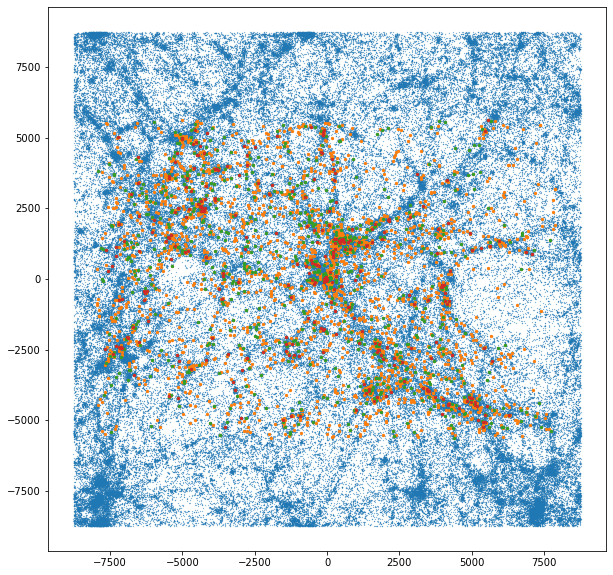

In [37]:
import os,sys,time,h5py
import illustris_python as il
import numpy as np
import pandas as pd
from astropy.cosmology import Planck15 as cosmo
import matplotlib.pyplot as plt

def query(dbcmd,database,
          host='nantai.ipmu.jp',user='bottrell',
          cnf_path='/home/connor.bottrell/.mysql/nantai.cnf'):
    '''Query database and return results as numpy array.'''
    import pymysql
    import numpy as np
    db = pymysql.connect(host=host,
                         user=user,
                         database=database,
                         read_default_file=cnf_path)
    c = db.cursor()
    c.execute(dbcmd)
    data = np.asarray(c.fetchall())
    c.close()
    db.close()
    return data

def submit(dbcmd,database,
           host='nantai.ipmu.jp',user='bottrell',
           cnf_path='/home/connor.bottrell/.mysql/nantai.cnf'):
    '''Submit command to database.'''
    import pymysql
    import numpy as np
    db = pymysql.connect(host=host,
                         user=user,
                         database=database,
                         read_default_file=cnf_path,
                         autocommit=True
                        )
    c = db.cursor()
    c.execute(dbcmd)
    c.close()
    db.close()
    return 

def Rotate(x,axis):
    '''return x-vector in instrument frame'''
    Xinst, Yinst, Zinst = _get_inst(axis)
    rx = np.zeros_like(x)
    rx[:,0] = np.dot(x,Xinst)
    rx[:,1] = np.dot(x,Yinst)
    rx[:,2] = np.dot(x,Zinst)
    return rx

def _get_angles(axis):
    '''return instrument coordinates in spherical coordinates'''
    angles = {'v0': (109.5,   0.,  0.),
              'v1': (109.5, 120.,  0.),
              'v2': (109.5,-120.,  0.),
              'v3': (   0.,   0.,  0.)}
    if len(axis) == 2:
        inclination, azimuth, posang = angles[axis]
    elif len(axis) == 5:
        inclination = float(axis[1:3])
        azimuth     = 0.
        posang      = float(axis[3: ])
    return inclination,azimuth,posang

def _get_inst(axis):
    '''return instrument coordinates in box coordinates '''
    inclination,azimuth,posang = _get_angles(axis)
    costheta= np.cos(np.radians(inclination))
    sintheta= np.sin(np.radians(inclination))
    cosphi  = np.cos(np.radians(azimuth))
    sinphi  = np.sin(np.radians(azimuth))
    cospa   = np.cos(np.radians(posang))
    sinpa   = np.sin(np.radians(posang)) 
    
    Xinst   = np.array([-cosphi*costheta*cospa - sinphi*sinpa,
                        -sinphi*costheta*cospa + cosphi*sinpa,
                         sintheta*cospa])
    Yinst   = np.array([ cosphi*costheta*sinpa - sinphi*cospa,
                         sinphi*costheta*sinpa + cosphi*cospa,
                        -sintheta*sinpa]) 
    Zinst   = np.array([sintheta * cosphi, 
                        sintheta * sinphi, 
                        costheta])

    Xinst /= np.sqrt(np.sum(Xinst**2))
    Yinst /= np.sqrt(np.sum(Yinst**2))
    Zinst /= np.sqrt(np.sum(Zinst**2))
    return Xinst,Yinst,Zinst

def Environment_Catalogue(basePath,massCatPath,sim,snap,axis,delv):
    '''
    mstar_lower and mstar_upper have log10(Mstar/Msun) units and are physical (i.e. Msun, not Msun/h). Requires that maximum masses have already been computed for every galaxy and are stored in the catalogues. These catalogues include masses for all subhalos with a stellar mass component.
    '''
    
    df = pd.DataFrame()
    
    little_h = cosmo.h
    ptNumStars = il.snapshot.partTypeNum('stars')
    ptNumGas = il.snapshot.partTypeNum('gas')
    ptNumDM = il.snapshot.partTypeNum('dm')
    
    # get list of halos to measure environments
    db_sim = sim.replace('-','_')
    database = f'Illustris{db_sim}'
    dbcmd = f'SELECT SubfindID FROM Subhalos WHERE SnapNum={snap}'
    db_subs = np.sort(query(dbcmd,database).flatten())
    db_subs = db_subs
    
    # get full list of subhalos from groupcats
    fields = ['SubhaloPos','SubhaloVel','SubhaloMassType','SubhaloFlag']
    cat = il.groupcat.loadSubhalos(basePath,snap,fields=fields)
    hdr = il.groupcat.loadHeader(basePath,snap)
    redshift,a2 = hdr['Redshift'],hdr['Time']
    Hz = cosmo.H(redshift).value/little_h # km/s/(Mpc/h)

    #kpc proxy for spectroscopic velocity cut (cosmological)
    delz_lim = delv/Hz*1000 # kpc/h
    
    boxSize = hdr['BoxSize']
    # periodic coordinates
    cat_coords = cat['SubhaloPos']
    cat_vels = cat['SubhaloVel']
    
    # get maximum masses from catalogue
    massmax = pd.read_csv(
        f'{massCatPath}/MassMax/{sim}_MassMaxInf_{snap:03}.csv'
    )
    
    # keep only subs in massmax catalogue
    # (i.e. flagged as cosmological and with stellar component)
    cat_subs = massmax['SubhaloID']
    cat_coords = cat_coords[cat_subs]
    cat_vels = cat_vels[cat_subs]
    cat_maxmass = massmax['MaxSubhaloMassType_stars'].values
    
    for sub in db_subs:
        dbid = f'{snap}_{sub}'
        mass_idx = massmax.SubhaloID==sub
        mass_rec = massmax.loc[mass_idx]
        sub_coords = cat_coords[cat_subs==sub]
        sub_maxmass = mass_rec['MaxSubhaloMassType_stars'].values[0]
        
        # initialize record
        r = {
            'dbID': dbid,
            'SnapNum': snap,
            'SubfindID': sub,
            'MaxMassType_stars': np.log10(sub_maxmass*1e10/little_h),
        }
        
        # periodic coordinate fix relative to subhalo
        rel_coords = cat_coords-sub_coords
        rel_coords[rel_coords>boxSize/2] -= boxSize
        rel_coords[rel_coords<-boxSize/2] += boxSize
        # coordinate change to instrument LOS and convert to kpc/h
        rel_coords = Rotate(rel_coords,axis)*a2
        rel_vels = Rotate(cat_vels,axis)
        sub_vels = rel_vels[cat_subs==sub]
        rel_vels = (rel_vels-sub_vels)
        
        # compute mass ratios for every halo 
        mu = cat_maxmass/sub_maxmass
        
        # fig,ax = plt.subplots(figsize=(10,10))
        # ax.scatter(rel_coords[:,0],rel_coords[:,-1],s=0.05)
        # ax.set_xlim(-17500,17500)
        # ax.set_ylim(-17500,17500)
        
        # compute 2d projected distance to every subhalo (physical kpc)
        proj_coords = np.sqrt(np.sum(rel_coords[:,:-1]**2,axis=1))
        # los distances and velocity to every galaxy in new coords
        delz_coords = rel_coords[:,-1]
        los_vels = rel_vels[:,-1]
        print(np.median(np.abs(los_vels)))
        
        for i,mu_min in zip(['Tiny','Minor','Major'],[0.01,0.10,0.25]):
                
            # find matches in mass ratio and cylinder
            idxs = mu>mu_min
            idxs = idxs & (proj_coords<8e3)
            # effective cosmological velocity cut
            idxs = idxs & (np.abs(delz_coords)<delz_lim)
            # peculiar velocity cut
            idxs = idxs & (np.abs(los_vels)<delv)
            # omit target halo (only flagged in major)
            idxs = idxs & (cat_subs!=sub)
            # numbers within sphere of radius
            r[f'{i}_Nin8Mpc']   = sum(idxs)
            r[f'{i}_Nin4Mpc']   = sum(idxs & (proj_coords<4e3))
            r[f'{i}_Nin2Mpc']   = sum(idxs & (proj_coords<2e3))
            r[f'{i}_Nin1Mpc']   = sum(idxs & (proj_coords<1e3))
            r[f'{i}_Nin500kpc'] = sum(idxs & (proj_coords<5e2))
            r[f'{i}_Nin100kpc'] = sum(idxs & (proj_coords<1e2))
            r[f'{i}_Nin50kpc']  = sum(idxs & (proj_coords<5e1))
            r[f'{i}_MassIn8Mpc_stars']   = np.log10((sub_maxmass + np.sum(cat_maxmass[idxs]))*1e10/little_h)
            r[f'{i}_MassIn4Mpc_stars']   = np.log10((sub_maxmass + np.sum(cat_maxmass[idxs & (proj_coords<4e3)]))*1e10/little_h)
            r[f'{i}_MassIn2Mpc_stars']   = np.log10((sub_maxmass + np.sum(cat_maxmass[idxs & (proj_coords<2e3)]))*1e10/little_h)
            r[f'{i}_MassIn1Mpc_stars']   = np.log10((sub_maxmass + np.sum(cat_maxmass[idxs & (proj_coords<1e3)]))*1e10/little_h)
            r[f'{i}_MassIn500kpc_stars'] = np.log10((sub_maxmass + np.sum(cat_maxmass[idxs & (proj_coords<5e2)]))*1e10/little_h)
            r[f'{i}_MassIn100kpc_stars'] = np.log10((sub_maxmass + np.sum(cat_maxmass[idxs & (proj_coords<1e2)]))*1e10/little_h)
            r[f'{i}_MassIn50kpc_stars']  = np.log10((sub_maxmass + np.sum(cat_maxmass[idxs & (proj_coords<5e1)]))*1e10/little_h)
            # nearest neighbour distances and masses
            sort_proj = np.argsort(proj_coords[idxs])
            proj_coords_sorted = np.array(proj_coords[idxs][sort_proj])
            cat_maxmass_sorted = cat_maxmass[idxs][sort_proj]
            for nn in range(5):
                if len(proj_coords_sorted)>=nn+1:
                    r[f'{i}_R{nn+1}'] = proj_coords_sorted[nn]
                    r[f'{i}_M{nn+1}_stars'] = np.log10(
                        cat_maxmass_sorted[nn]*1e10/little_h)
                else:
                    r[f'{i}_R{nn+1}'] = -1
                    r[f'{i}_M{nn+1}_stars'] = -1
                    
        for min_mass in [8,9,10]:
            idxs = cat_maxmass>(10**min_mass/1e10*little_h)
            idxs = idxs & (proj_coords<8e3)
            # effective cosmological velocity cut
            idxs = idxs & (np.abs(delz_coords)<delz_lim)
            # peculiar velocity cut
            idxs = idxs & (np.abs(los_vels)<delv)
            # omit target halo (only flagged in major)
            idxs = idxs & (cat_subs!=sub)
            # ax.scatter(rel_coords[idxs,0],rel_coords[idxs,-1],s=5)
            
            # numbers within sphere of radius
            r[f'MstarAbove{min_mass}_Nin8Mpc'] = sum(idxs)
            r[f'MstarAbove{min_mass}_Nin4Mpc'] = sum(idxs & (proj_coords<4e3))
            r[f'MstarAbove{min_mass}_Nin2Mpc'] = sum(idxs & (proj_coords<2e3))
            r[f'MstarAbove{min_mass}_Nin1Mpc'] = sum(idxs & (proj_coords<1e3))
            r[f'MstarAbove{min_mass}_Nin500kpc']= sum(idxs & (proj_coords<5e2))
            r[f'MstarAbove{min_mass}_Nin100kpc']= sum(idxs & (proj_coords<1e2))
            r[f'MstarAbove{min_mass}_Nin50kpc'] = sum(idxs & (proj_coords<5e1))
            r[f'MstarAbove{min_mass}_MassIn8Mpc_stars']= np.log10((sub_maxmass + np.sum(cat_maxmass[idxs]))*1e10/little_h)
            r[f'MstarAbove{min_mass}_MassIn4Mpc_stars']= np.log10((sub_maxmass + np.sum(cat_maxmass[idxs & (proj_coords<4e3)]))*1e10/little_h)
            r[f'MstarAbove{min_mass}_MassIn2Mpc_stars']= np.log10((sub_maxmass + np.sum(cat_maxmass[idxs & (proj_coords<2e3)]))*1e10/little_h)
            r[f'MstarAbove{min_mass}_MassIn1Mpc_stars']= np.log10((sub_maxmass + np.sum(cat_maxmass[idxs & (proj_coords<1e3)]))*1e10/little_h)
            r[f'MstarAbove{min_mass}_MassIn500kpc_stars']= np.log10((sub_maxmass + np.sum(cat_maxmass[idxs & (proj_coords<5e2)]))*1e10/little_h)
            r[f'MstarAbove{min_mass}_MassIn100kpc_stars']= np.log10((sub_maxmass + np.sum(cat_maxmass[idxs & (proj_coords<1e2)]))*1e10/little_h)
            r[f'MstarAbove{min_mass}_MassIn50kpc_stars']= np.log10((sub_maxmass + np.sum(cat_maxmass[idxs & (proj_coords<5e1)]))*1e10/little_h)
            # nearest neighbour distances and masses
            sort_proj = np.argsort(proj_coords[idxs])
            proj_coords_sorted = np.array(proj_coords[idxs][sort_proj])
            cat_maxmass_sorted = cat_maxmass[idxs][sort_proj]
            for nn in range(5):
                if len(proj_coords_sorted)>=nn+1:
                    r[f'MstarAbove{min_mass}_R{nn+1}'] = proj_coords_sorted[nn]
                    r[f'MstarAbove{min_mass}_M{nn+1}_stars'] = np.log10(
                        cat_maxmass_sorted[nn]*1e10/little_h)
                else:
                    r[f'MstarAbove{min_mass}_R{nn+1}'] = -1
                    r[f'MstarAbove{min_mass}_M{nn+1}_stars'] = -1

        df = df.append(r,ignore_index=True)
        
    df = df.astype({'SnapNum': int,'SubfindID': int})    
    return df

def Environment_SQL(cat,sim,snap,
                 host='nantai.ipmu.jp',user='bottrell',
                 cnf_path='/home/connor.bottrell/.mysql/nantai.cnf'):
    import pymysql
    database = f'Illustris{sim}'.replace('-','_')
    columns = list(cat.columns)
    db = pymysql.connect(host=host,
                         user=user,
                         database=database,
                         read_default_file=cnf_path,
                         autocommit=True
                        )
    c = db.cursor()
    for idx in cat.index:
        rec = cat.loc[idx]
        values = [str(rec[col]) for col in columns]
        values = ','.join(values)
        values = values.replace('nan','-99')
        values = values.replace('-inf','-99')
        values = values.replace('inf','-99')
        dbID = f'{rec["SnapNum"]}_{rec["SubfindID"]}'
        values = values.replace(f'{dbID}',f'"{dbID}"')
        dbcmd = [
            f'INSERT INTO Environments_LOS',
            '(',','.join(columns),')',
            f'VALUES',
            f'(',values,')',
        ]
        dbcmd = ' '.join(dbcmd)
        try:
            c.execute(dbcmd)
        except:
            continue
    c.close()
    db.close()
    return
    
def main():
    
    sim,snap=sys.argv[1],int(sys.argv[2])
    
    axis = 'v3' # z-axis
    delv = 1000 # km/s
    
    # group cat path
    basePath = f'/lustre/work/connor.bottrell/Simulations/IllustrisTNG/{sim}/output'
    # output schema path
    schemaCatPath = f'/lustre/work/connor.bottrell/Simulations/IllustrisTNG/Scripts/Schema/Catalogues'
    # catalogue of maximum masses
    massCatPath = f'/lustre/work/connor.bottrell/Simulations/IllustrisTNG/Scripts/Mergers/illustris_mergers/Catalogues'
    
    if not os.access(schemaCatPath,0):
        os.system(f'mkdir -p {schemaCatPath}')
        
    catName = f'{schemaCatPath}/{sim}_{snap:03}_Environments_LOS.csv'
    
    if not os.access(catName,0):
        cat = Environment_Catalogue(
            basePath, massCatPath, sim=sim, snap=snap, 
            axis=axis, delv=delv,
        )
        cat.to_csv(catName,index=False)
    else:
        cat = pd.read_csv(catName)
        
    Environment_SQL(cat,sim,snap)

if __name__=='__main__':
    
    main()

In [2]:
import os,sys,time,h5py
import illustris_python as il
import numpy as np
import pandas as pd
from astropy.cosmology import Planck15 as cosmo

def df_nullint(df):
    '''Convert int to nullible int types.'''
    dtypes = dict(df.dtypes)
    for key in dtypes.keys():
        if 'int' in str(dtypes[key]): 
            dtypes[key] = pd.Int64Dtype()
    return df.astype(dtypes) 

def query_df(dbcmd,database,
             host='nantai.ipmu.jp',user='bottrell',
             cnf_path='/home/connor.bottrell/.mysql/nantai.cnf'):
    '''Query database and return results as dataframe.'''
    import pymysql
    import pandas as pd
    db = pymysql.connect(host=host,
                         user=user,
                         database=database,
                         read_default_file=cnf_path)
    df = pd.read_sql(dbcmd, con=db)
    db.close()
    df = df_nullint(df)
    return df

database='IllustrisTNG50_1'
table='Environments'

dbcmd = f'SELECT * FROM {table} ORDER BY SnapNum,SubfindID'

outdir = '/lustre/work/connor.bottrell/Simulations/IllustrisTNG/TNG50-1/postprocessing/Share/Stone' 

df = query_df(dbcmd,database)
df.to_csv(f'{outdir}/{database.replace("_","-")}_{table}.csv',index=False)


In [7]:
df = pd.read_csv(f'{outdir}/{database.replace("_","-")}_{table}.csv')

In [23]:
cond = df['SnapNum']==84
cond = cond & (df['Major_CountSince2Gyr']==0)
cond = cond & (df['Minor_CountSince2Gyr']==0)
cond = cond & (df['Tiny_CountSince2Gyr']==0)
cond = cond & (df['Major_CountUntil2Gyr']==0)
cond = cond & (df['Minor_CountUntil2Gyr']==0)
cond = cond & (df['Tiny_CountUntil2Gyr']==0)
df.loc[cond]

,dbID,SnapNum,SubfindID,MaxMassSnap_stars,MaxMassType_stars,MaxMassInRadSnap_stars,MaxMassInRadType_stars,Major_CountSinceMainLeafProgenitor,Major_CountSinceHalfScaleFactor,Major_CountSince250Myr,...,Tiny_FutureMainProgenitorMaxMass_gas,Tiny_FutureMainProgenitorMaxMassInRad_stars,Tiny_FutureMainProgenitorMaxMassInRad_gas,Tiny_FutureNextProgenitorSnapNum,Tiny_FutureNextProgenitorSubfindID,Tiny_FutureNextProgenitorMaxMass_stars,Tiny_FutureNextProgenitorMaxMass_gas,Tiny_FutureNextProgenitorMaxMassInRad_stars,Tiny_FutureNextProgenitorMaxMassInRad_gas,Tiny_TreeFlag
145381,84_2,84,2,84,27.218300,83,18.871300,6,0,0,...,-1.0,-1.0,-1.0,-1,-1,-1.0,-1.0,-1.0,-1.0,0
145383,84_4,84,4,83,6.740410,83,4.264230,6,0,0,...,-1.0,-1.0,-1.0,-1,-1,-1.0,-1.0,-1.0,-1.0,0
145384,84_5,84,5,82,6.225490,82,3.970720,2,0,0,...,-1.0,-1.0,-1.0,-1,-1,-1.0,-1.0,-1.0,-1.0,0
145387,84_8,84,8,81,4.248370,81,3.097330,4,0,0,...,-1.0,-1.0,-1.0,-1,-1,-1.0,-1.0,-1.0,-1.0,0
145388,84_9,84,9,81,4.505260,81,3.230070,10,0,0,...,-1.0,-1.0,-1.0,-1,-1,-1.0,-1.0,-1.0,-1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148536,84_761521,84,761521,81,0.084038,81,0.048941,1,0,0,...,-1.0,-1.0,-1.0,-1,-1,-1.0,-1.0,-1.0,-1.0,0
148537,84_762287,84,762287,81,0.071455,83,0.052839,0,0,0,...,-1.0,-1.0,-1.0,-1,-1,-1.0,-1.0,-1.0,-1.0,0
148538,84_769145,84,769145,83,0.102029,84,0.073141,3,0,0,...,-1.0,-1.0,-1.0,-1,-1,-1.0,-1.0,-1.0,-1.0,0
148539,84_769892,84,769892,81,0.155039,82,0.110619,2,0,0,...,-1.0,-1.0,-1.0,-1,-1,-1.0,-1.0,-1.0,-1.0,0
